In [1]:
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/Noticias_BCRP/notebooks")

## Importar librerias

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import pickle
import seaborn as sns
import nltk
from nltk.corpus import  stopwords
nltk.download("stopwords")
import sys
### importar libreriar locales
sys.path.append("/content/drive/My Drive/Colab Notebooks/Noticias_BCRP/src")
### para limpieza y preprocesamiento
from limpieza import clean_text_noticias
from limpieza import remove_stopwords
from filter_words import make_stopwords_filter
from filter_words import remove_stopwords_from_list_texts
from vectorization_word2vec_boew import vectorization_word2vec
import datetime as dt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### libreria web scraping

In [3]:
! pip install -q fake_useragent
! pip install -q selenium

     |████████████████████████████████| 911kB 2.8MB/s 


In [4]:
from selenium import webdriver

In [ ]:
!apt update
!apt install -q chromium-chromedriver
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox') 
options.add_argument('--disable-dev-shm-usage')

In [7]:
from bs4 import BeautifulSoup
from scraping_elcomercio_gestion import *

### Libreria Text Recognition

In [ ]:
# !sudo apt install -q tesseract-ocr
# !pip install -q pytesseract
# !pip install -q PyMuPDF

In [ ]:
# !cp "../models/spa.traineddata" /usr/share/tesseract-ocr/4.00/tessdata/
# !ls -l /usr/share/tesseract-ocr/4.00/tessdata/

In [ ]:
# import glob
# from os.path import join
# from text_recognition import text_recognigtion

## Cargar los modelos para  clasificacion de noticias

In [11]:
### se considero , la noticias de gestion con el tag bcr, la noticias escaneadas en pdf, la noticas de espectaculo, deporte, entretenimiento , senamhi y vida social
### cargar los modelos para realizar la vectorizacion word2vec
modelo5=pickle.load(open("../models/experimento3/modelo.pkl","rb"))
### cargar el modelo de standarizacion de word2vec
scaler=pickle.load(open("../models/experimento3/scaler.pkl","rb"))
### cargar el modelo support vector machine
svm_model=pickle.load(open("../models/experimento3/svm_model.pkl", 'rb'))
### ver pag 27, 57 y 61 , son los errores donde falla
df_statistics=pd.read_pickle("../data/intermediated/df_statistics_total.pkl")

## Extracción de noticias (Peru21, ElComercio y Gestion)

In [12]:
### open web browser 
browser = webdriver.Chrome('chromedriver',options=options)

In [13]:
### urls para realizar el scraping
# urls=["https://elcomercio.pe/archivo/todas/2020-04-18/","https://gestion.pe/archivo/todas/2020-04-18/","https://peru21.pe/archivo/todas/2020-04-18/"]
urls=["https://elcomercio.pe/ultimas-noticias/","https://gestion.pe/ultimas-noticias/","https://peru21.pe/archivo/"]

# urls=["https://gestion.pe/noticias/bcr/","https://gestion.pe/noticias/rin/","https://gestion.pe/noticias/exportaciones-peruanas/",
#       "https://gestion.pe/noticias/bvl/","https://gestion.pe/noticias/tipo-de-cambio/","https://gestion.pe/noticias/inversion-publica/",
#       "https://gestion.pe/noticias/inversion-privada/","https://gestion.pe/noticias/precios-al-consumidor/"]

# urls=["https://elcomercio.pe/noticias/senamhi/","https://elcomercio.pe/noticias/horoscopo/","https://elcomercio.pe/noticias/espectaculos/","https://elcomercio.pe/noticias/gastronomia/",
#       "https://elcomercio.pe/noticias/tecnologia/","https://elcomercio.pe/deporte-total/futbol-peruano/","https://elcomercio.pe/archivo/luces/vida-social/"]

# urls=["https://gestion.pe/noticias/bcr/"]
list_url_noticia=[]
for url in urls:
  ### indicar al browser la url a visitar
  browser.get(url)
  ### realizar el scroll para obtener todo el contenido html de la pagina
  source_code=scroll_browser(browser)
  ### aplicar el beautifulsoup para realizar un manejo mas dinamico del contenido html
  soup=BeautifulSoup(source_code, "html.parser")
  url_base="/".join(url.split("/")[0:3])
  ### extraer todos los links de noticias
  list_url_noticia.extend(get_links_news(url_base,soup))
len(list_url_noticia)

278

In [14]:
df=scraping_news(list_url_noticia)

fecha:2020-07-05T13:50:00-05:00 || fuente:elcomercio || titulo: HOY Barcelona vs. Villarreal EN VIVO ONLINE vía DirecTV Sports: ver aquí EN DIRECTO el partido por la Liga Santander || url:https://elcomercio.pe/deporte-total/futbol-mundial/barcelona-vs-villarreal-en-vivo-en-directo-online-ver-directv-sports-liga-santander-nczd-noticia/
fecha:2020-07-05T13:29:39-05:00 || fuente:elcomercio || titulo: Murió Summer Taylor, la manifestante que fue atropellada en una protesta en Seattle | VIDEO || url:https://elcomercio.pe/mundo/eeuu/protestas-en-seattle-4-de-julio-un-carro-atropella-a-manifestantes-de-black-lives-matter-y-mata-a-una-persona-y-deja-dos-heridos-estados-unidos-video-noticia/
fecha:2020-07-05T13:33:40-05:00 || fuente:elcomercio || titulo: Vizcarra anuncia referéndum para eliminar la inmunidad parlamentaria y proyecto sobre impedimentos para postular || url:https://elcomercio.pe/politica/congreso-martin-vizcarra-anuncia-referendum-sobre-inmunidad-y-proyecto-sobre-impedimentos-par

## Cargar Data Etiquetada del scraping

elcomercio    182
gestion        51
peru21         45
Name: fuente, dtype: int64


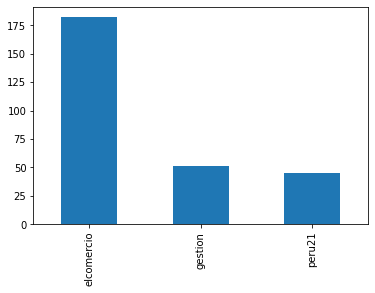

In [15]:
### ver la distribución de frecuencia de noticias publicadas en el dia
print(df["fuente"].value_counts())
df["fuente"].value_counts().plot.bar()
plt.show()

## Text Recognition

In [ ]:
# rutaEntrada = "../data/raw"
# # patron = "20200226093211_NOTICIAS-BCRP_20200226.pdf"
# # patron ="NOTICIAS_BCRP_20190904.pdf"
# patron = "NOTICIAS_BCRP_202004*.pdf"
# flist=glob.glob(join(rutaEntrada,patron))
# df=text_recognigtion(flist)
# df

## Preprocesamiento de noticias

In [16]:
### filtrar aquellas noticias que no tienen contenido
df=df[df["texto"].str[:]!=""].copy()
### limpiar y estandarizar el contenido
df["texto_limpio"]=clean_text_noticias(df["texto"])
### obtener el corpus de stopwords en español
stop_w=stopwords.words("spanish")
### filtar los stopwords estandar en español
df["texto_filter_stopwords"]=remove_stopwords(df["texto_limpio"],stopwords=stop_w)
print(df.shape)
df.head()

(148, 7)


,fuente,fecha,url,titulo,texto,texto_limpio,texto_filter_stopwords
2,elcomercio,2020-07-05T13:33:40-05:00,https://elcomercio.pe/politica/congreso-martin...,Vizcarra anuncia referéndum para eliminar la ...,"Tras lamentar la actuación del Congreso, el pr...",tras lamentar actuacion del congreso president...,tras lamentar actuacion congreso presidente re...
13,elcomercio,2020-07-05T13:03:22-05:00,https://elcomercio.pe/politica/reforma-politic...,Congreso convoca a sesión plenaria para esta ...,Minutos antes de que el mandatario Martín Vizc...,minutos antes que mandatario martin vizcarra b...,minutos mandatario martin vizcarra brinde mens...
29,elcomercio,Sun Jul 05 2020 18:34:30 GMT+0000 (Coordinated...,https://elcomercio.pe/videos/historias/quien-e...,¿Quién era ‘Chente’?: La trágica historia del ...,"El libro ‘El diario del Chavo del Ocho’, revel...",libro diario del chavo del ocho revela que che...,libro diario chavo ocho revela chente realidad...
41,elcomercio,2020-07-05T11:55:00-05:00,https://elcomercio.pe/politica/congreso/congre...,Congreso deja puerta abierta a sentenciados p...,El trote apresurado de la primera legislatura ...,trote apresurado primera legislatura del congr...,trote apresurado primera legislatura congreso ...
46,elcomercio,2020-07-05T11:36:30-05:00,https://elcomercio.pe/gastronomia/guias/delive...,"Delivery de mi barrio: 10 chifas bonitos, bue...",A pesar del reinicio de actividades económicas...,pesar del reinicio actividades economicas que ...,pesar reinicio actividades economicas incluye ...


In [17]:
### cargar el estadistico de stopwords
list_texts = [[h.strip() for h in doc.split()  ] for doc in df["texto_filter_stopwords"]]
## seleccionando el metodo de remover stopwords
method = 'INFOR'
cutoff_type = 'p'
cutoff_val = 0.60
## obtener el dataframe de los stopwods identificados bajo el enfoque de la teoria de la informacion
df_filter = make_stopwords_filter(df_statistics,method = method,cutoff_type = cutoff_type,cutoff_val = cutoff_val )
## obtener la lista de palabras estopweords identificados bajo el enfoque de la teoria de la informacion
list_words_filter = list(df_filter.index)
## filtra los stopwords de la informacion
list_texts_filter = remove_stopwords_from_list_texts(list_texts, list_words_filter)
df["texto_filter_stopwordsInfo"]=[" ".join(i).strip() for i in list_texts_filter]
df=df[df["texto_filter_stopwordsInfo"]!=""].copy()
print(df.shape)
df.head()

(148, 8)


,fuente,fecha,url,titulo,texto,texto_limpio,texto_filter_stopwords,texto_filter_stopwordsInfo
2,elcomercio,2020-07-05T13:33:40-05:00,https://elcomercio.pe/politica/congreso-martin...,Vizcarra anuncia referéndum para eliminar la ...,"Tras lamentar la actuación del Congreso, el pr...",tras lamentar actuacion del congreso president...,tras lamentar actuacion congreso presidente re...,congreso presidente martin vizcarra referendum...
13,elcomercio,2020-07-05T13:03:22-05:00,https://elcomercio.pe/politica/reforma-politic...,Congreso convoca a sesión plenaria para esta ...,Minutos antes de que el mandatario Martín Vizc...,minutos antes que mandatario martin vizcarra b...,minutos mandatario martin vizcarra brinde mens...,minutos mandatario martin vizcarra mensaje omi...
29,elcomercio,Sun Jul 05 2020 18:34:30 GMT+0000 (Coordinated...,https://elcomercio.pe/videos/historias/quien-e...,¿Quién era ‘Chente’?: La trágica historia del ...,"El libro ‘El diario del Chavo del Ocho’, revel...",libro diario del chavo del ocho revela que che...,libro diario chavo ocho revela chente realidad...,libro chavo realidad historia serie
41,elcomercio,2020-07-05T11:55:00-05:00,https://elcomercio.pe/politica/congreso/congre...,Congreso deja puerta abierta a sentenciados p...,El trote apresurado de la primera legislatura ...,trote apresurado primera legislatura del congr...,trote apresurado primera legislatura congreso ...,congreso reforma politica noche junta habia in...
46,elcomercio,2020-07-05T11:36:30-05:00,https://elcomercio.pe/gastronomia/guias/delive...,"Delivery de mi barrio: 10 chifas bonitos, bue...",A pesar del reinicio de actividades económicas...,pesar del reinicio actividades economicas que ...,pesar reinicio actividades economicas incluye ...,actividades incluye fase restaurantes servicio...


In [18]:
### obtener la vectorizacion word2vec
news=[ i.split() for i in df["texto_filter_stopwordsInfo"]]
prom_vects=vectorization_word2vec(texts=news,modelo=modelo5)
### estandarizar los valores obtenidos del word2vec
prom_vects=scaler.transform(prom_vects)
prom_vects.shape

(148, 200)

## Prediccion 

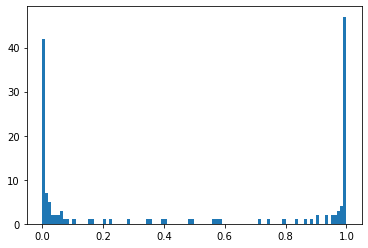

In [19]:
## ver la distribucion de probabilidad de las predicciones del modelo
plt.hist(svm_model.predict_proba(prom_vects)[:,1],bins=100)
plt.show()

In [ ]:
df["conf"]=svm_model.predict_proba(prom_vects)[:,1]
df["pred"]=df["conf"].apply(lambda x : 1 if x >=0.8 else 0)

In [ ]:
# from sklearn.metrics import roc_curve,auc, classification_report,confusion_matrix
# plt.rcParams["figure.figsize"] = (8,5)
# plt.figure()
# false_positive_rate, recall, thresholds = roc_curve(df["etiqueta"], df["conf"])
# roc_auc_lg = auc(false_positive_rate, recall)
# plt.title('Receiver Operating Characteristic (ROC)')
# plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc_lg)
# plt.legend(loc='lower right')
# plt.plot([0,1], [0,1], 'r--')
# plt.xlim([0.0,1.0])
# plt.ylim([0.0,1.0])
# plt.ylabel('Recall')
# plt.xlabel('Fall-out (1-Specificity)')
# plt.show()
# print('AUC score:', roc_auc_lg)

In [ ]:
# ### matriz de confusion
# plt.rcParams["figure.figsize"] = (8,5)
# conf = confusion_matrix(df["etiqueta"], df["pred"], labels = [0,1])
# label_y = ['NO','YES']
# label_x = ['NO_PRED', 'YES_PRED']
# sns.heatmap(conf, annot=True, xticklabels=label_x, yticklabels=label_y,fmt=".1f")
# plt.show()

0    83
1    65
Name: pred, dtype: int64


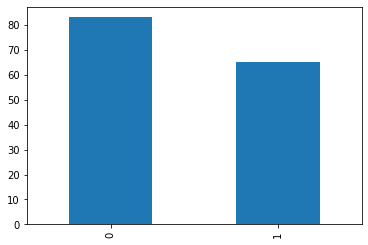

In [21]:
## ver la distribucion de probabilidad de las noticias
print(df["pred"].value_counts())
df["pred"].value_counts().plot.bar()
plt.show()

## Topic Modelling

In [22]:
### Se logra un mejor performance con 45 topicos
ldamodel=pickle.load(open("../models/topic_modelling/lda_models/model_{}.pkl".format(45), "rb" ))

In [23]:
names_topic={0:"GOBIERNO EJECUTIVO",1:"ENCAJE MONETARIO",2:"SECTOR TURISMO",3:"TRANSPORTE VEHICULAR",4:"PROYECTO GASODUCTO SUR",5:"PROYECTO CHINCHEROS",
                 6:"DESARROLLO COMPETITIVO PERUANO",7:"VIVIENDA SOCIAL",8:"EMPLEO FORMAL", 9:"INVERSION PUBLICA",10:"PRECIOS DEL COMBUSTIBLE",
                 11:"DEFICIT FISCAL",12:"AGUA POTABLE",13:"LAVA JATO - ODEBRECHT",14:"PRECIOS AL CONSUMIDOR",15:"BOLSA DE VALORES LIMA",16:"CONGRESO DE LA REPUBLICA",
                 17:"COMERCIO EXTERIOR",18:"MERCADO PERUANO",19:"INVERSION PRIVADA",20:"SECTOR PESQUERO",21:"DEMANDA JUDICIAL",22:"FONDO DE PENSIONES",
                 23:"TARIFA ENERGIA ELECTRICA",24:"CIRCULACION MONEDA NACIONAL",25:"MERCADO MUNDIAL",26:"PRODUCCION PETROLERA",27:"MEDIDAS DEL MEF",
                 28:"SALUD PUBLICA",29:"FENOMENO DEL NIÑO COSTERO",30:"EXPECTATIVAS DE INFLACION",31:"RECAUDACION TRIBUTARIA - SUNAT",
                 32:"RESERVAS INTERNACIONALES NETAS",33:"INDICES DEL PBI",34:"SECTOR AGRICOLA",35:"MONEDAS ALUSIVAS",
                 36:"SECTOR MINERO",37:"TASA DE REFERENCIA",38:"PRODUCTOS DE EXPORTACION",39:"CREDITOS BANCARIOS",
                 40:"DIRECTORIO BCRP ",41:"ECONOMIA LATINOAMERICANA",42:"PROYECTOS DE LEY", 43:"TIPO DE CAMBIO",
                 44:"ECONOMIA PERUANA" }
dictionary=pickle.load( open( "../models/topic_modelling/dictionary.pkl", "rb" ) )

In [24]:
text=[ i.split() for i in  df[df["pred"]== 1]["texto_filter_stopwordsInfo"]]
titulo=[ i for i in  df[df["pred"]== 1]["titulo"]]
# titulo=[i[0:70] for i in df[df["pred"]==1]["texto_filter_stopwordsInfo"]]
for n,(i,ind) in enumerate(zip(text,titulo)):
  plt.figure(figsize=(15,10))
  i_bow=dictionary.doc2bow(i)
  df = pd.DataFrame(ldamodel.get_document_topics(i_bow), columns=['topic','probability'])
  df.replace({"topic": names_topic},inplace=True)
  df=df.set_index('topic')
  df.sort_values("probability",ascending=False,inplace=True)
  plt.title(ind)
  sns.barplot(x='probability', y=df.index, data=df)

Output hidden; open in https://colab.research.google.com to view.